# PyGlove: Efficiently Exchanging ML Ideas as Code

This notebook serves as supplimentary material for the paper "PyGlove: Efficiently Exchange ML Ideas as Code". It provides runnable code examples through a complete toy ML experiment in which an image classifier is trained and validated. The results are not intended to reach optimal accuracy but simply to illustrate PyGlove at practical level with readable code.

In [ ]:
!pip install pyglove

## Annotating ML Commponents with Flexible Standards

In this section, we will illustrate the use of PyGlove, mirroring the example in Figure 2 of the paper. First, we will create a set of typical classes to define an ML experiment with Keras. A root `MLExperiment` will object will hold all the components of this ML system, including data, model, training, and validation. Then we annotate these component classes them with PyGlove, which will provide a flexible standard for manipulating and sharing code, as described in the paper. We will then illustrate how to apply a rule to modify the code and how that rule can be shared.


In [ ]:
import abc
import tensorflow as tf

class MLExperiment:

  def __init__(self, model, dataset, loss, optimizer, num_epochs=5):
    self._model = model
    self._dataset = dataset
    self._loss = loss
    self._optimizer = optimizer
    self._num_epochs = num_epochs
  
  def train_and_evaluate(self):
    (tr_x, tr_y), (te_x, te_y) = self._dataset.load_data()
    tr_x = tr_x / 255.0
    te_x = te_x / 255.0
    self._model.compile(
        optimizer=self._optimizer,
        loss=self._loss,
        metrics=['accuracy'])
    self._model.fit(tr_x, tr_y, epochs=self._num_epochs)
    _, test_acc = self._model.evaluate(te_x, te_y, verbose=2)
    return test_acc
                        
# Components for datasets.
class Dataset(metaclass=abc.ABCMeta):
  @abc.abstractproperty
  def num_classes(self):
    pass

  @abc.abstractmethod
  def load_data(self):
    pass
  
class Cifar100(Dataset):
  @property
  def num_classes(self):
    return 100

  def load_data(self):
    return tf.keras.datasets.cifar100.load_data()

class Mnist(Dataset):
  @property
  def num_classes(self):
    return 10

  def load_data(self):
    (tr_x, tr_y), (te_x, te_y) = tf.keras.datasets.mnist.load_data()
    tr_x = tf.cast(tf.reshape(tr_x, (-1, 28, 28, 1)), tf.float32)
    te_x = tf.cast(tf.reshape(te_x, (-1, 28, 28, 1)), tf.float32)
    return (tr_x, tr_y), (te_x, te_y)

Sequential = tf.keras.Sequential
Conv2D = tf.keras.layers.Conv2D
Dense = tf.keras.layers.Dense
Flatten = tf.keras.layers.Flatten
ReLU = tf.keras.layers.ReLU
SparseCategoricalCrossentropy = tf.keras.losses.SparseCategoricalCrossentropy
Adam = tf.keras.optimizers.Adam

At this point, we can create an ML experiment and run it:

In [ ]:
def experiment():
  # The return value represents an ML experiment that is composed
  # by its sub-components.
  return MLExperiment(
    model=Sequential([
        Conv2D(16, (3, 3), padding='same', activation=ReLU()),
        Conv2D(32, (1, 1), padding='same', activation=ReLU()),
        Flatten(),
        Dense(150),
        Dense(10, activation='softmax')
    ]),
    dataset=Mnist(),
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.01),
    num_epochs=2)

exp = experiment()

# `exp` is a regular runtime object without
# a readable representation.
print(exp)

# Run training.
exp.train_and_evaluate()        

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/2
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2220 - accuracy: 0.9363
Epoch 2/2
1875/1875 [==============================] - 20s 10ms/step - loss: 0.1538 - accuracy: 0.9551
313/313 - 1s - loss: 0.1662 - accuracy: 0.9520 - 893ms/epoch - 3ms/step


0.9520000219345093

However, the experiment represented by `exp` is not easy to modify. To perform any nontrivial edit, users would typically need to create another `MLExperiment` object (or to pass hyperparameters through a deep call stack, etc.). As an example, we consider the case in which we want to swap all Conv2D to SeparateConv2D, as we illustrated in Figure 2 of our paper.

Now let's see how PyGlove can help. By annotating the component classes with `@pg.symbolize`, the `exp` object becomes much more flexible, allows modifications, and can even be manipulated by general rules, as we will see. This is how to annotate the experiment:

In [ ]:
import pyglove as pg

# `pg.symbolize` is the decorator that can upgrade
# a regular class with symbolic programmability.
MLExperiment = pg.symbolize(MLExperiment)
Mnist = pg.symbolize(Mnist)
Cifar100 = pg.symbolize(Cifar100)
Sequential = pg.symbolize(Sequential)
Conv2D = pg.symbolize(Conv2D)
Dense = pg.symbolize(Dense)
Flatten = pg.symbolize(Flatten)
ReLU = pg.symbolize(ReLU)
SparseCategoricalCrossentropy = pg.symbolize(SparseCategoricalCrossentropy)
Adam = pg.symbolize(Adam)

# Now `exp` is created as a symbolic object,
# which has a human-readable string representation.
exp = experiment()
print(exp)

MLExperiment(
  model = Sequential(
    layers = [
      0 : Conv2D(
        filters = 16,
        kernel_size = (3, 3),
        strides = (1, 1),
        padding = 'same',
        data_format = None,
        dilation_rate = (1, 1),
        groups = 1,
        activation = ReLU(
          max_value = None,
          negative_slope = 0.0,
          threshold = 0.0
        ),
        use_bias = True,
        kernel_initializer = 'glorot_uniform',
        bias_initializer = 'zeros',
        kernel_regularizer = None,
        bias_regularizer = None,
        activity_regularizer = None,
        kernel_constraint = None,
        bias_constraint = None
      ),
      1 : Conv2D(
        filters = 32,
        kernel_size = (1, 1),
        strides = (1, 1),
        padding = 'same',
        data_format = None,
        dilation_rate = (1, 1),
        groups = 1,
        activation = ReLU(
          max_value = None,
          negative_slope = 0.0,
          threshold = 0.0
        ),
        us

Now that it is annotated, it can now be manipulated by the locations of the sub-components, for example:

In [ ]:
# The experiment object is now ready for direct manipulation.
# We show the diff before and after.
exp2 = exp.clone()
pg.patch(exp2, {
    'optimizer.learning_rate': 0.02,
    'num_epochs': 1
})
print(pg.diff(exp, exp2))

# We now run the modified experiment,
# which only train the dataset for 1 epoch.
exp2.train_and_evaluate()

MLExperiment(
  optimizer = Adam(
    learning_rate = Diff(
      left = 0.01,
      right = 0.02
    )
  ),
  num_epochs = Diff(
    left = 2,
    right = 1
  )
)
1875/1875 [==============================] - 20s 10ms/step - loss: 0.3877 - accuracy: 0.8928
313/313 - 1s - loss: 0.4065 - accuracy: 0.8701 - 915ms/epoch - 3ms/step


0.8701000213623047

As illustrated in the following figure, we can use an apply rule to patch the experiment to produce a new one with the original convolution replaced with a SeparableConv.

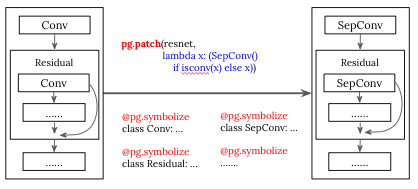

The rule can be coded as follows:

In [ ]:
SeparableConv2D = pg.symbolize(tf.keras.layers.SeparableConv2D)

# Replace all Conv2D with SeparableConv2D in the model.
# The rule does not know the existence of `MyExperiment`.
exp3 = exp.clone()
pg.patch(exp3, lambda k, v: SeparableConv2D(v.filters, v.kernel_size, padding=v.padding) if isinstance(v, Conv2D) else v)
print(pg.diff(exp, exp3))

# Train with SeparableConv2D.
exp3.train_and_evaluate()

MLExperiment(
  model = Sequential(
    layers = [
      0 = Diff(
        left = Conv2D(
          filters = 16,
          kernel_size = (3, 3),
          strides = (1, 1),
          padding = 'same',
          data_format = None,
          dilation_rate = (1, 1),
          groups = 1,
          activation = ReLU(
            max_value = None,
            negative_slope = 0.0,
            threshold = 0.0
          ),
          use_bias = True,
          kernel_initializer = 'glorot_uniform',
          bias_initializer = 'zeros',
          kernel_regularizer = None,
          bias_regularizer = None,
          activity_regularizer = None,
          kernel_constraint = None,
          bias_constraint = None
        ),
        right = SeparableConv2D(
          filters = 16,
          kernel_size = (3, 3),
          strides = (1, 1),
          padding = 'same',
          data_format = None,
          dilation_rate = (1, 1),
          depth_multiplier = 1,
          activation = None,
   

0.9146999716758728

## Expressing Ideas through Patching

Ideas in ML can be described by conceptual rules that manipulate the experiment representation. In this section, we further show the power of patching rules with examples. With the ability of encapsulating the rules and making them reusable across experiments.

### Patching with absolute locations

Patching can be programmed against the absolute locations of experiment components under of the root experiment object (an instance of `MLExperiment` in our case).

In [ ]:
# Make a copy of `exp` before we manipulate it.
exp4 = exp.clone()
pg.patch(exp4, {
    'optimizer.learning_rate': 0.02,
})

# The diff between the original and mutated experiments
# contains the diff on both learning rate.
print(pg.diff(exp, exp4))

MLExperiment(
  optimizer = Adam(
    learning_rate = Diff(
      left = 0.01,
      right = 0.02
    )
  )
)


### Patching by relative locations

Patching rules can also be programmed based on components' relative locations.

In [ ]:
@pg.patcher([
  ('learning_rate', pg.typing.Float(min_value=0.))
])
def change_lr(target, learning_rate):
  def rule(k, v, p):
    # k: a key path object representing the location of current node (the node 
    #    that is being transformed.
    # v: the value of current node.
    # p: the parent node of current node.

    # The change learning rate rule is not depend on
    # the containing classes, but only depend on the
    # key name of the learning rate. This rule is more
    # robust than previous rule which depends on the
    # absolute location.
    if (k and k.key in ['learning_rate', 'lr'] and isinstance(v, float)):
      return learning_rate
    else:
      return v
  return rule

exp5 = exp.clone()
pg.patch(exp5, change_lr(learning_rate=0.03))
print(pg.diff(exp, exp5))

MLExperiment(
  optimizer = Adam(
    learning_rate = Diff(
      left = 0.01,
      right = 0.03
    )
  )
)


### Patching by component types

Besides locations, patching rules can be coded based the component types.
This allows more general rules which are decoupled from the topology of the containing objects. 

In [ ]:
LeakyReLU = pg.symbolize(tf.keras.layers.LeakyReLU)

@pg.patcher()
def relu_to_leaky_relu(unused):
  def rule(k, v, p):
    return LeakyReLU() if isinstance(v, ReLU) else v
  return rule

exp6 = exp.clone()
pg.patch(exp6, relu_to_leaky_relu())
print(pg.diff(exp, exp6))

MLExperiment(
  model = Sequential(
    layers = [
      0 = Conv2D(
        activation = Diff(
          left = ReLU(
            max_value = None,
            negative_slope = 0.0,
            threshold = 0.0
          ),
          right = LeakyReLU(
            alpha = 0.3
          )
        )
      ),
      1 = Conv2D(
        activation = Diff(
          left = ReLU(
            max_value = None,
            negative_slope = 0.0,
            threshold = 0.0
          ),
          right = LeakyReLU(
            alpha = 0.3
          )
        )
      )
    ]
  )
)


### Patching with more complex rules

In complex scenarios, patching may require pattern matching against the symbolic tree based on common assumptions, or depend on the evaluation of the objects involved, instead of solely on their symbolic representations. We use 3 examples here to show how complex rules can be expressed with PyGlove.

#### Replacing the dataset

To replace the dataset of an image classifier, 
we not only need to substitute the dataset object, but also to adjust the width of the classification head to align with the number of classes for the dataset. Therefore, (1) We need to find the classification head in the model, which is usually the last `Dense` layer. This can be done by querying the symbolic tree using `pg.query`. (2) We need to get the number of classes for the dataset, which is done by evaluating its `num_classes` property.


In [ ]:
def dataset_by_name(name):
  if name == 'cifar100':
    return Cifar100()
  elif name == 'mnist':
    return Mnist()
  else:
    raise NotImplemented()

# The number of logits is dependent on the dataset.
@pg.patcher()
def change_dataset(exp, name):
  dataset = dataset_by_name(name)
  r = pg.query(exp, where=lambda v: isinstance(v, Dense))
  return {
      f'{list(r.keys())[-1]}.units': dataset.num_classes,
      'dataset': dataset
  }

exp7 = exp.clone()
pg.patch(exp7, change_dataset(name='cifar100'))
print(pg.diff(exp, exp7))

MLExperiment(
  model = Sequential(
    layers = [
      4 = Dense(
        units = Diff(
          left = 10,
          right = 100
        )
      )
    ]
  ),
  dataset = Diff(
    left = Mnist(),
    right = Cifar100()
  )
)


#### Scaling model width

Another common scenario is to scaling up a neural network by increasing its width. In this example, we simultaneously widen all Conv layers by a given constant factor. We start out by identifying the `filters` of all `Conv2D` layers, and then scaling up their original widths.

In [ ]:
@pg.patcher([
  ('factor', pg.typing.Float(min_value=1e-8))
])
def scale_width(exp, factor):
  def rule(k, v, p):
    if isinstance(p, Conv2D) and k.key == 'filters':
      return max(8, int(v * factor))
    return v
  return rule
  
exp8 = exp.clone()
pg.patch(exp8, scale_width(factor=2.0))
print(pg.diff(exp, exp8))

MLExperiment(
  model = Sequential(
    layers = [
      0 = Conv2D(
        filters = Diff(
          left = 16,
          right = 32
        )
      ),
      1 = Conv2D(
        filters = Diff(
          left = 32,
          right = 64
        )
      )
    ]
  )
)


#### Creating a search space from a fixed model

PyGlove allows rules to turn a fixed model into a model search space, which can then be automatically tuned. (See complete example in the [Automatic Tuning section](#scrollTo=i9iPuLXJIMJB))

In [ ]:
@pg.patcher()
def filter_search_space(exp):
  def rule(k, v, p):
    if isinstance(p, Conv2D) and k.key == 'filters':
      return pg.oneof([v // 2, v, v * 2])
    return v
  return rule
  
exp9 = exp.clone()
pg.patch(exp9, filter_search_space())
# Print search space.
print(pg.dna_spec(exp9))

Space({
  0 = 'model.layers[0].filters': Choices(num_choices=1, [
    (0): 8
    (1): 16
    (2): 32
  ])
  1 = 'model.layers[1].filters': Choices(num_choices=1, [
    (0): 16
    (1): 32
    (2): 64
  ])
})


## Exchanging Ideas with Network Effects

Patching-rules are be composable. As a result, a small set of rules can produce a rich array of experiment setups. This reduces the engineering cost of trying multiple ideas. Here we show this compositionality:

In [ ]:
exp10 = exp.clone()

# Applying 3 rules to `exp10` in chains,
# which will end up with an experiment with
# all desired changes.
pg.patch(exp10, [
    'change_lr?0.003',
    'scale_width?factor=2.0',
    'change_dataset?name=cifar100'
])
print(pg.diff(exp, exp10))

MLExperiment(
  model = Sequential(
    layers = [
      0 = Conv2D(
        filters = Diff(
          left = 16,
          right = 32
        )
      ),
      1 = Conv2D(
        filters = Diff(
          left = 32,
          right = 64
        )
      ),
      4 = Dense(
        units = Diff(
          left = 10,
          right = 100
        )
      )
    ]
  ),
  dataset = Diff(
    left = Mnist(),
    right = Cifar100()
  ),
  optimizer = Adam(
    learning_rate = Diff(
      left = 0.01,
      right = 0.003
    )
  )
)


As we can see from the diff above, the resulted experiment has:

* (1) Its original `Mnist` dataset replaced with `Cifar100`;
* (2) Doubled filter size for all `Conv2D` layers; and
* (3) a new learning rate of 0.03 instead of the original 0.01.

## Serving Machine Learning End-to-End

Above, we went into detail into a single case study that illustrated the power of PyGlove's rules. In this section, we will take a step back and describe in more general terms how PyGlove can serve ML experimentation end-to-end. We use our toy ML program to exemplify aspects stages of the experimentation cycle, as presented in Figure 9 of our paper. The aspects are: reproducibility, development, iteration, auto-tuning, and release.

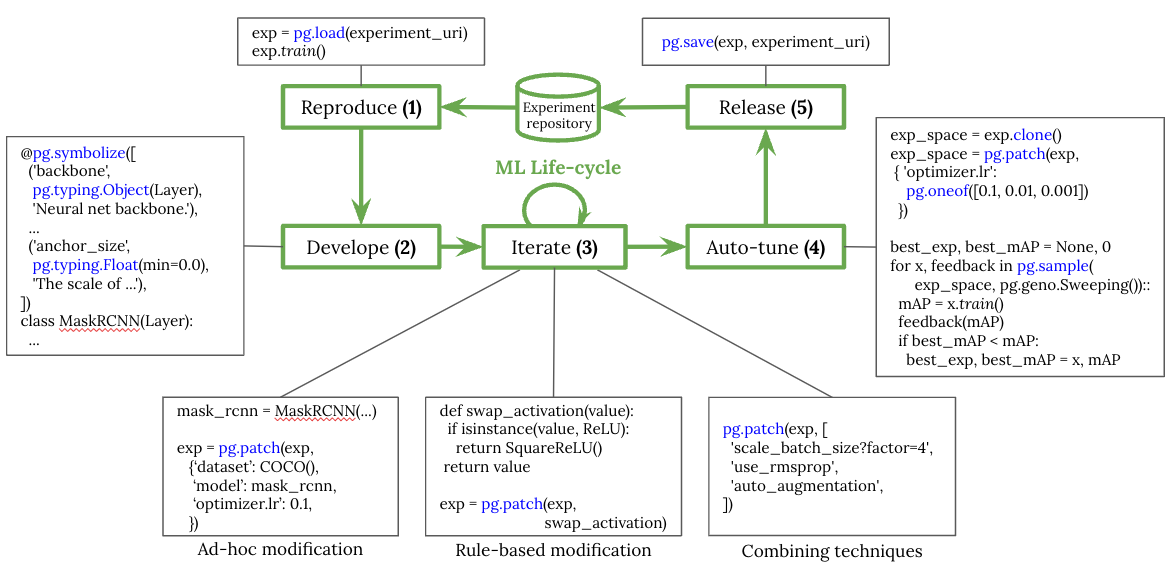

We start with the `exp` object we have from the previous section, at stage 5 and work our way through all stages.

### Release (saving the code)

Releasing an ML experiment in PyGlove is to serialize it to a file or a distributed storage. It keeps both the type information and argument values into serialized string, therefore `pg.load` can load the object solely based on the serialized content.

In [ ]:
# Save experiment to a file.
# `pg.save` can also be hooked up with a distributed storage.

exp_id = 'my_experiment.json'
pg.save(exp, exp_id)

### Reproducibility

It is important to be able to reproduce results. To enable this, PyGlove allows loading a serialized experiment and running it.

In [ ]:
exp11 = pg.load(exp_id)

assert pg.eq(exp, exp11)
exp11.train_and_evaluate()

Epoch 1/2
1875/1875 [==============================] - 20s 10ms/step - loss: 0.2322 - accuracy: 0.9330
Epoch 2/2
1875/1875 [==============================] - 20s 11ms/step - loss: 0.1512 - accuracy: 0.9552
313/313 - 1s - loss: 0.1181 - accuracy: 0.9642 - 849ms/epoch - 3ms/step


0.9642000198364258

### Developement and Troubleshooting

Development can be done in a manner similar to traditional object-oriented programming---indeed, PyGlove is fully compatible with Python syntax. In addition, the code can be manipulated through rules as explained in previous examples. This is enabled by annotations done with the `@pg.symbolize` decorator. `pg.symbolize` accepts an optional specification for argument validation rules, which will be automatically invoked during object creation and modification. This can aid troubleshooting by making human errors easier to catch.

In [ ]:
class Optimizer:
  pass

# Symbolic validation can be done at creation and mutation time
# automatically, with the optional validation rules provided for
# component arguments.
@pg.symbolize([
    ('learning_rate', pg.typing.Float(min_value=0)),
])
class MyNewOptimizer(Optimizer):
  def __init__(self, learning_rate):
    pass

try:
  # Mistakenly provided learning_rate will be caught at construction.
  MyNewOptimizer(learning_rate=-1.0)
except Exception as e:
  print(e)

my_opt = MyNewOptimizer(learning_rate=1.0)

try:
  # Mistakenly provided learning_rate will be caught at construction.
  pg.patch(my_opt, {'learning_rate': -0.5})
except Exception as e:
  print(e)


Value -1.0 is out of range (min=0, max=None). (path=learning_rate)
Value -0.5 is out of range (min=0, max=None). (path=learning_rate)


### Iteration

To improve the system, a phase of iteration over different ideas is often necessary. For this, it is helpful to share code, which can also be done through patching-rules. We have seen abundant examples for how to do that in previous sections. Here, we want to show how users can easily inspect the experiment using `pg.query`, which is often helpful for debugging.

In [ ]:
# Query the location of all relu layers.
pg.query(exp, where=lambda v: isinstance(v, tf.keras.layers.ReLU))

{'model.layers[0].activation': ReLU(max_value=None, negative_slope=0.0, threshold=0.0),
 'model.layers[1].activation': ReLU(max_value=None, negative_slope=0.0, threshold=0.0)}

In [ ]:
# Query values by path.
pg.query(exp, '.*learning_rate')

{'optimizer.learning_rate': 0.01}

### Automatic tuning

Often there is a stage of hyperparameter optimization, or even architecture search / AutoML, where the model is improved through automatic means. We can do this using PyGlove's search primtives. Indeed, AutoML is one of the main intended uses of PyGlove ([paper](https://papers.nips.cc/paper/2020/file/012a91467f210472fab4e11359bbfef6-Paper.pdf)). For example, if we want to tune the filter sizes, we can do the following:

In [ ]:
# Tune the Conv2D filters.
exp_tuning = pg.patch(exp.clone(), [
  filter_search_space(),
  {'num_epochs': 1}
])

# Print the search space information.
print(pg.dna_spec(exp_tuning))

Space({
  0 = 'model.layers[0].filters': Choices(num_choices=1, [
    (0): 8
    (1): 16
    (2): 32
  ])
  1 = 'model.layers[1].filters': Choices(num_choices=1, [
    (0): 16
    (1): 32
    (2): 64
  ])
})


In [ ]:
# Do hyperparameter sweeping on the search space.
best_acc, best_exp = 0., None
for exp, feedback in pg.sample(exp_tuning, pg.geno.Sweeping()):
  test_acc = exp.train_and_evaluate()
  if best_acc < test_acc:
    best_acc, best_exp = test_acc, exp
  print(feedback.id, feedback.dna, test_acc)
  feedback(test_acc)

print(f'Best experiment (accuracy={best_acc}): f{best_exp}')

1875/1875 [==============================] - 13s 7ms/step - loss: 0.2612 - accuracy: 0.9247
313/313 - 1s - loss: 0.1865 - accuracy: 0.9449 - 693ms/epoch - 2ms/step
1 DNA([0, 0]) 0.9448999762535095
1875/1875 [==============================] - 19s 10ms/step - loss: 0.2451 - accuracy: 0.9278
313/313 - 1s - loss: 0.1449 - accuracy: 0.9538 - 924ms/epoch - 3ms/step
2 DNA([0, 1]) 0.9538000226020813
1875/1875 [==============================] - 32s 17ms/step - loss: 0.2782 - accuracy: 0.9237
313/313 - 1s - loss: 0.1773 - accuracy: 0.9509 - 1s/epoch - 4ms/step
3 DNA([0, 2]) 0.9509000182151794
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2343 - accuracy: 0.9339
313/313 - 1s - loss: 0.1699 - accuracy: 0.9513 - 652ms/epoch - 2ms/step
4 DNA([1, 0]) 0.9513000249862671
1875/1875 [==============================] - 19s 10ms/step - loss: 0.2312 - accuracy: 0.9364
313/313 - 1s - loss: 0.1692 - accuracy: 0.9478 - 811ms/epoch - 3ms/step
5 DNA([1, 1]) 0.9477999806404114
1875/1875 [====

## A Comparison with Non-Symbolic Approaches

In this section, we want to show how PyGlove's approach to ML compares to non-symbolic alternatives. Most non-symbolic ML approaches have hyperparameter containers of some sort. For simplicity, we show an approach based on dataclass-based hyperparameter containers.

### Module development without PyGlove

We have shown how to develop ML component in [the first section](#scrollTo=_VqiGDJpfplD). Here we show the code for their hyperparameter containers. Though hyperparameter containers can look quite different in different solutions, they are similar in nature and design patterns. Throughout our examples, the hyperparameter containers are represented as an `HParams` object. 

In [ ]:
import abc
import dataclasses
from typing import List, Optional, Tuple, Union

# Hyper-parameter interfaces.
class HParam:
  @abc.abstractmethod
  def build(self):
    pass

class DatasetHParam(HParam):
  pass

class LayerHParam(HParam):
  pass

class LossHParam(HParam):
  pass

class OptimizerHParam(HParam):
  pass

# Concrete hyperparameter containers.
@dataclasses.dataclass
class ExperimentHParam(HParam):
  dataset: DatasetHParam
  model: LayerHParam
  loss: LossHParam
  optimizer: OptimizerHParam
  num_epochs: int

  def build(self):
    return MLExperiment(
        dataset=self.dataset.build(),
        model=self.model.build(),
        loss=self.loss.build(),
        optimizer=self.optimizer.build(),
        num_epochs=self.num_epochs)

@dataclasses.dataclass
class MnistHParam(DatasetHParam):
  def build(self):
    return Mnist()

@dataclasses.dataclass
class Cifar100HParam(DatasetHParam):
  def build(self):
    return Cifar100()

@dataclasses.dataclass
class AdamHParam(OptimizerHParam):
  learning_rate: float

  def build(self):
    return Adam(learning_rate=self.learning_rate)

@dataclasses.dataclass
class SparseCategoricalCrossentropyHParam(LossHParam):
  def build(self):
    return SparseCategoricalCrossentropy()

@dataclasses.dataclass
class SequentialHParam(LayerHParam):
  layers: List[LayerHParam]
  
  def build(self):
    return Sequential([l.build() for l in self.layers])

@dataclasses.dataclass
class FlattenHParam(LayerHParam):
  def build(self):
    return Flatten()

@dataclasses.dataclass
class Conv2DHParam(LayerHParam):
  filters: int
  kernel_size: Union[int, Tuple[int, int]]                    
  padding: str
  activation: Optional[LayerHParam]

  def build(self):
    if self.activation:
      activation = self.activation.build()
    else:
      activation = None
    return Conv2D(
        self.filters, self.kernel_size,
        padding=self.padding, activation=activation)

@dataclasses.dataclass
class DenseHParam(LayerHParam):
  units: int
  activation: Optional[str] = None

  def build(self):
    return Dense(self.units, activation=self.activation)

@dataclasses.dataclass
class ReLUHParam(LayerHParam):
  def build(self):
    return ReLU()

### Iterating on ML experiments without PyGlove

With the ML components being immutable, the user will need to create editable HParams object in order to change the experiment.

In [ ]:
# In order to create experiment, we will need to
# create its hyperparameter container.
exp_hparam = ExperimentHParam(
    dataset=MnistHParam(),
    model=SequentialHParam([
        Conv2DHParam(filters=16, kernel_size=(3, 3), padding='same',
                     activation=ReLUHParam()),
        Conv2DHParam(filters=32, kernel_size=(1, 1), padding='same',
                     activation=ReLUHParam()),
        FlattenHParam(),
        DenseHParam(100),
        DenseHParam(10, activation='softmax')
    ]),
    loss=SparseCategoricalCrossentropyHParam(),
    optimizer=AdamHParam(learning_rate=1.0),
    num_epochs=2)

# Through the Builder pattern (https://en.wikipedia.org/wiki/Builder_pattern),
# we get an experiment out of a hyperparameter container.
exp = exp_hparam.build()
exp.train_and_evaluate()

Epoch 1/2
1875/1875 [==============================] - 17s 9ms/step - loss: 473.5936 - accuracy: 0.1002
Epoch 2/2
1875/1875 [==============================] - 16s 8ms/step - loss: 46.1786 - accuracy: 0.0992
313/313 - 1s - loss: 16.8709 - accuracy: 0.1028 - 733ms/epoch - 2ms/step


0.10279999673366547

To obtain another experiment, we will need to modify the `exp_hparam`.

In [ ]:
import copy

exp_hparam2 = copy.copy(exp_hparam)
exp_hparam2.optimizer.learning_rate = 0.02
exp2 = exp_hparam2.build()
exp2.train_and_evaluate()

Epoch 1/2
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3483 - accuracy: 0.9054
Epoch 2/2
1875/1875 [==============================] - 16s 9ms/step - loss: 0.2787 - accuracy: 0.9207
313/313 - 1s - loss: 0.3071 - accuracy: 0.9227 - 745ms/epoch - 2ms/step


0.9226999878883362

### Issues of non-symbolic approaches

#### (1) Redundant code and overhead for synchronization

Almost for every ML component, there will be a paired hyperparameter container class associated with it. For example, if we introduce a new optimizer `MyOptimizer`, we will have to introduce an hyperparameter container `MyOptimizerHParam` for it.

In [ ]:
class MyOptimizer(Optimizer):
  def __init__(self, learning_rate):
    pass

@dataclasses.dataclass
class MyOptimizerHParam(OptimizerHParam):
  learning_rate: float

  def build(self):
    return MyOptimizer(learning_rate=learning_rate)

# Consider if we introduce more hyperparameters in the class
# we will have to update both classes.

Also, which class should validate the parameters? If we do this at `MyOptimizer` side, creating of `MyOptimizerHParam` will not fail when human mistakes take place. If we do at `MyOptimizerHParam` side, users cannot reuse `MyOptimizer` unless through `MyOptimizerHParam`. If we add both to them, redundancy and consistency are concerns.

#### (2) The separation between HParam/Component makes it more difficult to craft rules

For example, if we are going to change the dataset for an experiment. We will need to access the `num_classes` property of the chosen dataset, and update the width of the last Dense layer.

In [ ]:
import typing

def change_dataset_hp(exp_hparam):
  dataset_hparam = Cifar100HParam()
  exp_hparam.dataset = dataset_hparam
  
  # We need to obtain an dataset object
  # in order to inspect the number of
  # classes from it.
  dataset = dataset_hparam.build()
  num_classes = dataset.num_classes

  # Traverse `exp_hparam` to get the final
  # Dense layer is a bit tricky. We will
  # need to traverse the hyperparameter
  # containers to get DenseHParams. 
  # What if `Dense` can also be created from
  # another `HParam` subclass?
  denses = []
  def traverse(v):
    if isinstance(v, DenseHParam):
      denses.append(v)
    if isinstance(v, (list, tuple)):
      for i in range(len(v)):
        traverse(v[i])
    elif isinstance(v, dict):
      for cv in v.values():
        traverse(cv)
    else:
      for field_name, _ in typing.get_type_hints(v.__class__).items():
        traverse(getattr(v, field_name))
  traverse(exp_hparam)
  denses[-1].units = num_classes
  return exp_hparam

exp_hparam3 = copy.copy(exp_hparam)
change_dataset_hp(exp_hparam3)
print(exp_hparam3.dataset)
print(exp_hparam3.model.layers[-1])

Cifar100HParam()
DenseHParam(units=100, activation='softmax')


### A Comparison of Code 

For a more intuitive comparison on the development and usage of ML components between PyGlove and non-symbolic approach, we include two snapshots for showing the code differences, one for component development, and the other for their usages.    

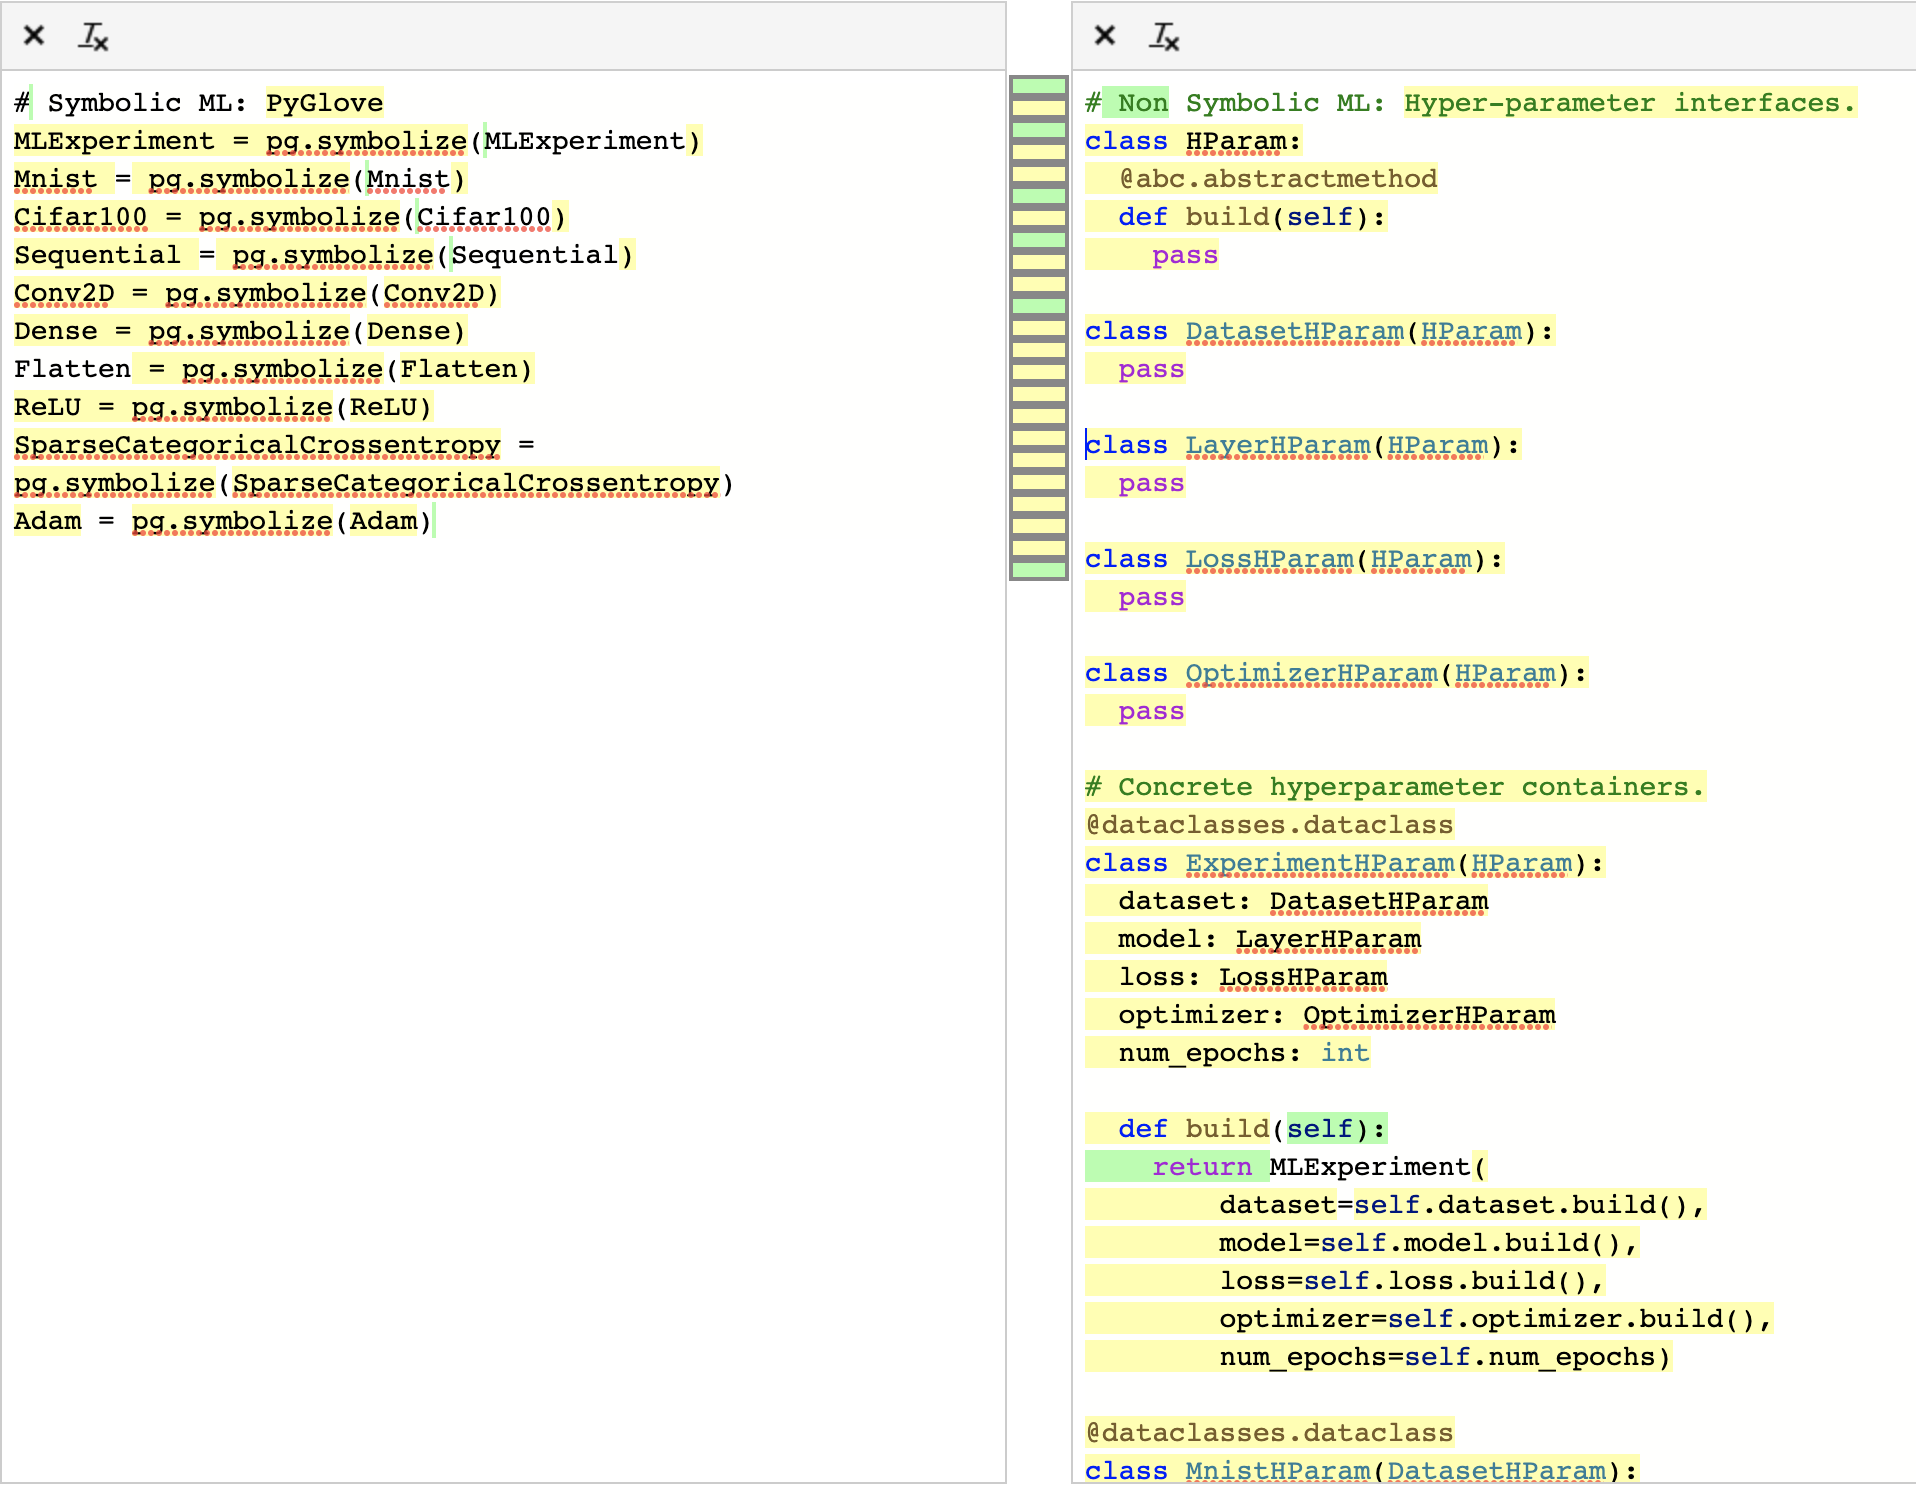

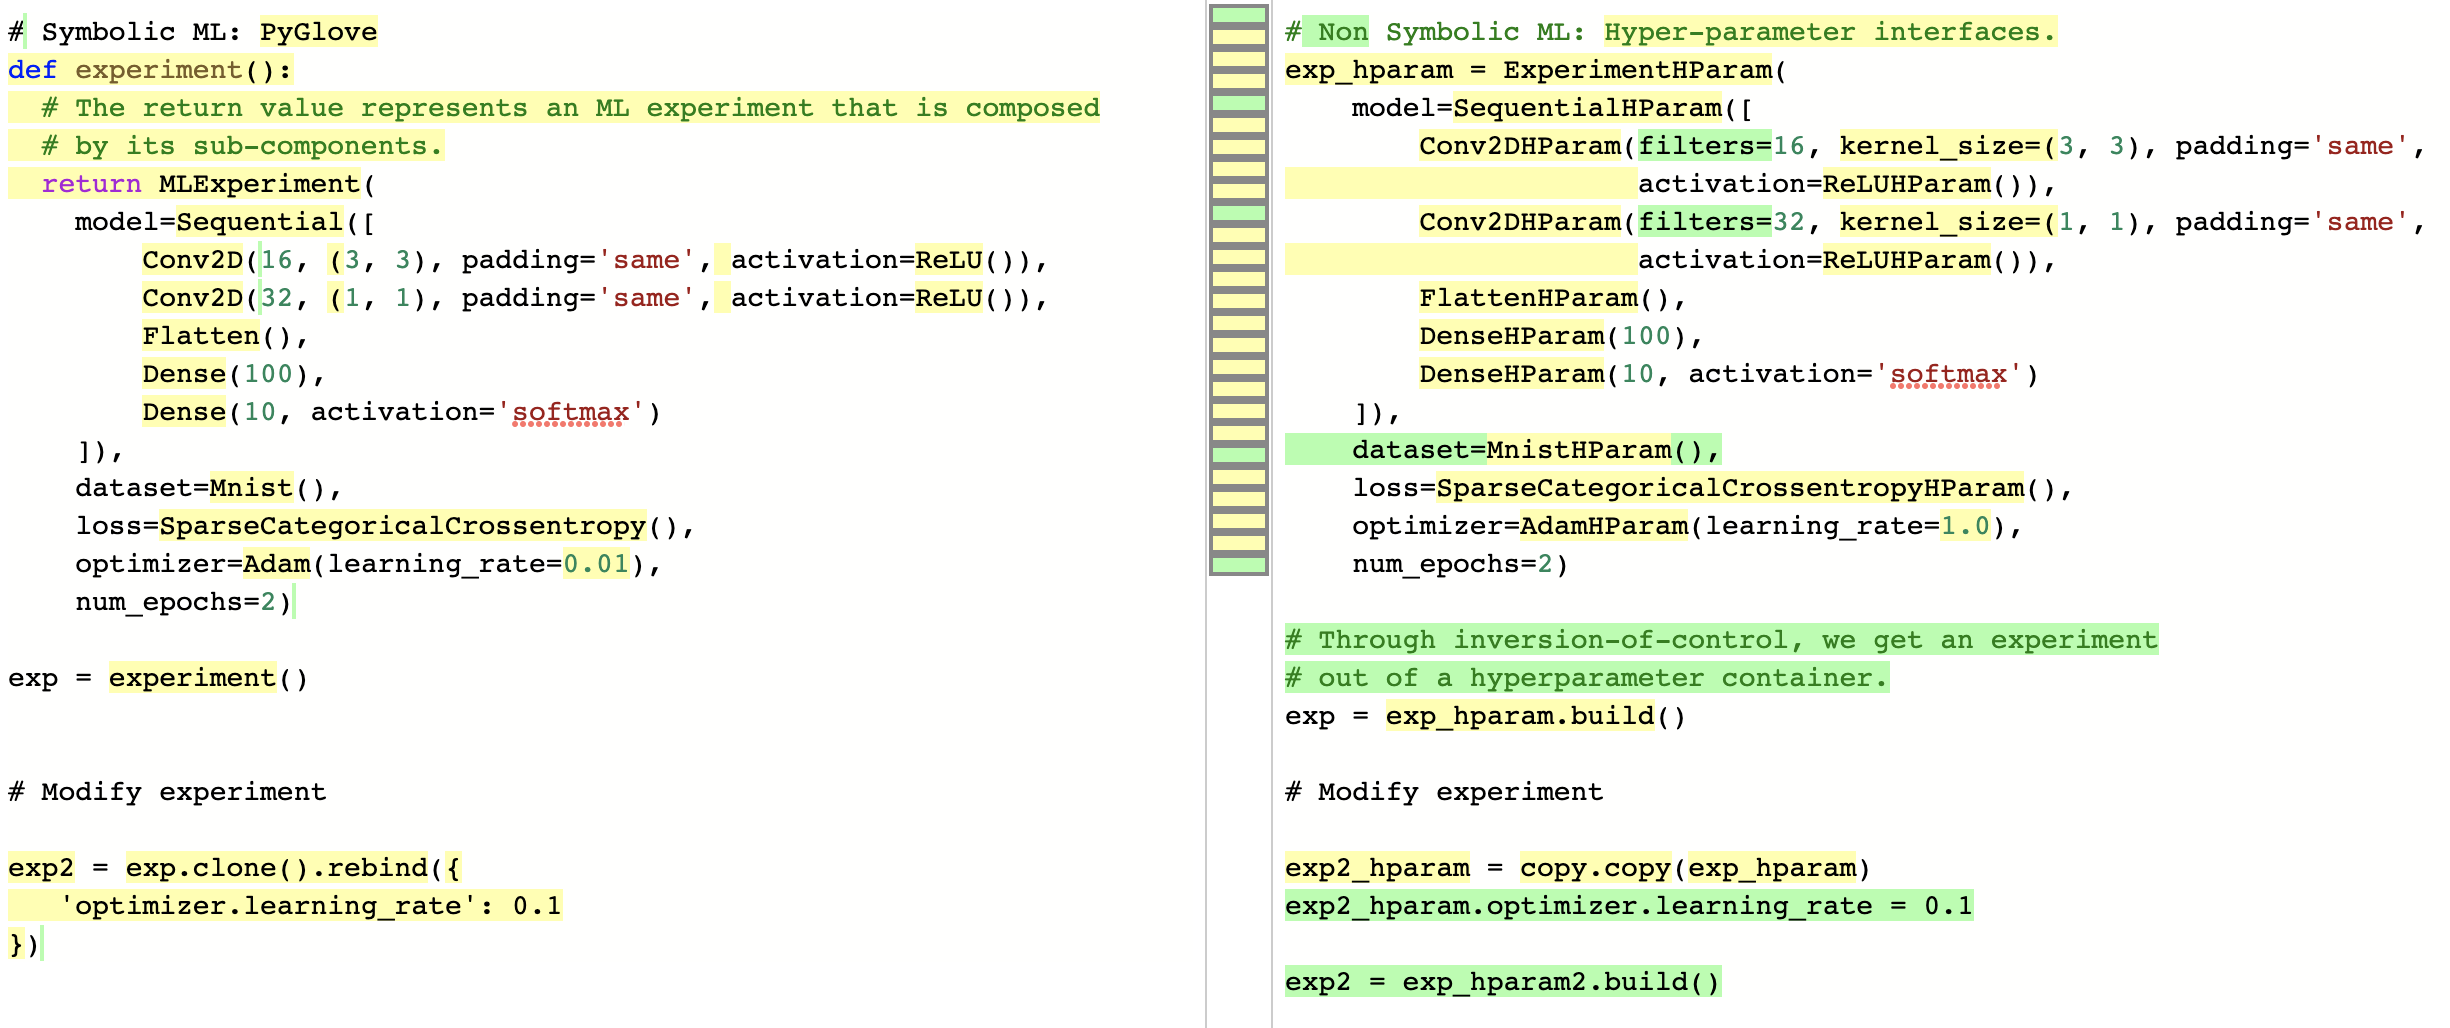

## Summary

We conclude this notebook with a summary of PyGlove's approach to ML:

* PyGlove enables a flexible standard for ML components - therefore, objects can be directly manipulated with ease;
* Based on such flexible standard, PyGlove provides a rule-based approach to encapsulate ideas in ML. Such rules are powerful, reusable and can be horizontally applied to different experiments;
* Patching rules are compositional, which leads to network effects among the ML ideas;
* PyGlove can serve ML end-to-end with simplicity, from reproduction to release;
* Comparing to non-symbolic approaches, ML components developed with PyGlove provide better usability with less code, and is more friendly for patching rules.